# Word and Tag Classes

In this task we will look for classes of words that occur in similar contexts. The aim is to find these similar words and cluster them into classes so that these classes can be used for building more robust language models.

In this notebook we include the code for computing a full class hierarchy of words and then we run four experiments on Czech and English and on words and tags.

The full outputs of the algorithms can be found in the `output_word_classes/` directory.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from pathlib import Path

from dataset import read_word_list, pairs
from datastructures import WordIndexedSparseMatrix, Classes

# create output directory
Path("output_word_classes/").mkdir(parents=True, exist_ok=True)

In [2]:
def mi(clr, cl, cr, N):
    '''Computes the Mutual Information using bigram and marginal unigram counts'''
    if clr == 0:
        return 0
    return clr / N * np.log2(clr * N / (cl * cr))

In [3]:
def compute_loss(a, b, bigram_counts, left_unigram_counts, right_unigram_counts, s, q, N):
    '''Computes Mutual Information Loss for given merge candidate words `a` and `b`'''
    Lab = s[a] + s[b] - q[a, b] - q[b, a]
    
    # q(a+b, a+b)
    AB_bigram_count = bigram_counts[a, a] + bigram_counts[a, b] + bigram_counts[b, a] + bigram_counts[b, b]
    AB_left_unigram_count = left_unigram_counts[a] + left_unigram_counts[b]
    AB_right_unigram_count = right_unigram_counts[a] + right_unigram_counts[b]
    Lab -= mi(AB_bigram_count, AB_left_unigram_count, AB_right_unigram_count, N)
    
    # q(l, a+b)
    left_nonzero_words = bigram_counts.union_keys(a, b, "column")
    for l in left_nonzero_words:
        if l == a or l == b:
            continue

        AB_bigram_count = bigram_counts[l, a] + bigram_counts[l, b]
        Lab -= mi(AB_bigram_count, left_unigram_counts[l], AB_right_unigram_count, N)
    
    # q(a+b, r)
    right_nonzero_words = bigram_counts.union_keys(a, b, "row")
    for r in right_nonzero_words:
        if r == a or r == b:
            continue

        AB_bigram_count = bigram_counts[a, r] + bigram_counts[b, r]
        Lab -= mi(AB_bigram_count, AB_left_unigram_count, right_unigram_counts[r], N)
    
    return Lab

In [4]:
def compute_full_hierarchy(data_path, input_data_type, occurence_threshold=10, line_limit=8000, save_class_members_at_k=15):
    # Load the list of lines
    line_list = read_word_list(data_path)
    word_list = [word.split("/", 1)[input_data_type] for word in line_list]

    # Process first 8000 words
    word_list = word_list[:line_limit]

    # Create list of bigrams
    bigram_list = list(pairs(word_list, distance=1))
    bigram_list_mapped = bigram_list

    # Find N most common words and prepare the initial word classes
    _unigram_counts = Counter(word_list)
    _classes_list = [word for word, count in _unigram_counts.items() if count >= occurence_threshold]
    classes = Classes(_classes_list)

    N = len(bigram_list)

    # For logging the merges
    merge_history = []

    k = len(classes.get_unique_classes())
    while k > 1:
        # Go through the bigrams and change the words to word classes
        bigram_list_mapped = list(map(classes.map_bigram_to_classes, bigram_list_mapped))

        # Count the bigrams and left/right marginal counts
        left_unigram_counts = Counter(l for l,r in bigram_list_mapped)
        right_unigram_counts = Counter(r for l,r in bigram_list_mapped)
        bigram_counts = WordIndexedSparseMatrix.from_bigram_list(bigram_list_mapped)

        # Compute the q_k subterms
        q = WordIndexedSparseMatrix()
        for lword, rword in bigram_counts.keys():
            q[lword, rword] = mi(bigram_counts[lword, rword], left_unigram_counts[lword], right_unigram_counts[rword], N)

        # Compute the Mutual Information of the data
        total_mi = sum(mi for mi in q.values())

        # Compute the s_k subterms
        s = {}
        for a in left_unigram_counts:
            s[a] = sum(q.get_sparse_row(a).values()) + sum(q.get_sparse_column(a).values()) - q[a, a]

        # Find the merging class pair candidate
        min_Lab = None
        min_a = None
        min_b = None
        unique_classes = classes.get_unique_classes()
        for i, a in enumerate(unique_classes):
            for b in unique_classes[i+1:]:
                Lab = compute_loss(a, b, bigram_counts, left_unigram_counts, right_unigram_counts, s, q, N)

                if min_Lab is None or min_Lab > Lab:
                    min_Lab = Lab
                    min_a = a
                    min_b = b

#         Inspect the merging of the classes "The" and "the"
#         if min_a in ["the", "The"] or min_b in ["the", "The"]:
#             print(min_a, min_b, min_Lab)
#             print("the", "The", compute_loss("the", "The", bigram_counts, left_unigram_counts, right_unigram_counts, s, q, N))
#             print("The", "the", compute_loss("The", "the", bigram_counts, left_unigram_counts, right_unigram_counts, s, q, N))

        classes.merge_classes(min_a, min_b)
        k -= 1

        if k == save_class_members_at_k:
            class_members = classes.get_class_members()

        merge_history.append({
            "word A": min_a,
            "word B": min_b,
            "loss": min_Lab,
            "total mi": total_mi
        })
    return merge_history, class_members

In [5]:
from IPython.core.display import display, HTML
from graphviz import Digraph

def display_experiment(experiment_name, merge_history, class_members):
    pd.set_option('display.max_rows', 30)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('float_format', '{:,.14f}'.format)

    display(HTML(f'<h1>{experiment_name} Results</h1>'))
    display(HTML(f'<h2>Merge history</h2>'))
    merge_history_df = pd.DataFrame(merge_history)
    display(merge_history_df)
    
    # output to file
    filename = experiment_name.replace(" ", "_")
    merge_history_df.to_csv(f"output_word_classes/merge_history_{filename}.csv")

    if class_members is not None:
        display(HTML(f'<h2>Class members for 15 classes</h2>'))
        display(pd.DataFrame({
            "class name": class_members.keys(),
            "members":  class_members.values()
        }))
    display(HTML(f'<h2>Class merge tree visualization</h2>'))
    # Create Digraph object
    dot = Digraph(experiment_name)
    dot.attr(rankdir='LR')
    for step in merge_history:
        w1 = id1 = step["word A"]
        w2 = id2 = step["word B"]
        idfix = {":": "<colon>", " ": "<space>", "Z:-------------":"Z-------"}
        id1 = idfix[id1] if id1 in idfix else id1
        id2 = idfix[id2] if id2 in idfix else id2
            
        dot.node(id1, w1)
        dot.node(id2, w2)
        dot.edge(id1, id2)
    dot.render(directory='merge_trees').replace('\\', '/')
    display(dot)

# Word Classes

## Task description
Compute a full class hierarchy of words using the first 8,000 words of those data, and only for words occurring 10 times or more (use the same setting for both languages). Ignore the other words for building the classes, but keep them in the data for the bigram counts and all the formulas that use them (including the Mutual Information, the interim sums in the "Tricks", etc.). For details on the algorithm, use the Brown et al. paper available form SIS; some formulas are wrong in the paper, however, so please see the corrections in the slides (formulas for Trick #4). Note the history of the merges, and attach it to your homework. Now run the same algorithm again, but stop when reaching 15 classes. Print out all the members of your 15 classes and attach them too.

,word A,word B,loss,total mi
0,case,subject,0.00219684113872,4.99633675507534
1,may,cannot,0.00266947319525,4.99413991393662
2,individuals,structure,0.00267514354556,4.99147044074137
3,there,It,0.00347983534987,4.98879529719582
4,less,even,0.00365609607424,4.98531546184595
...,...,...,...,...
106,most,some,0.18938388761316,2.77901109642913
107,see,and,0.19353511743594,2.58962720881599
108,",",of,0.22611734433435,2.39609209138005
109,see,most,0.30032981475690,2.16997474704570


,class name,members
0,in,"[on, in, me, :, from, at, only, under, between]"
1,.,[.]
2,and,"[as, and, for, (, but, than, if, or, when]"
3,",","[,]"
4,they,"[I, it, we, It, they, there]"
5,by,"[much, with, that, this, by, all, which, nearly, how, what, differ]"
6,most,"[certain, one, our, my, short, same, many, more, several, most, other, such, even, its, distinct, domesticated, great, slight, long, manner, less, an, different, domestic, wild]"
7,animals,"[facts, species, subject, ), cases, varieties, structure, conditions, variation, case, animals, plants, state, nature, individuals, races, breeds]"
8,the,[the]
9,of,[of]


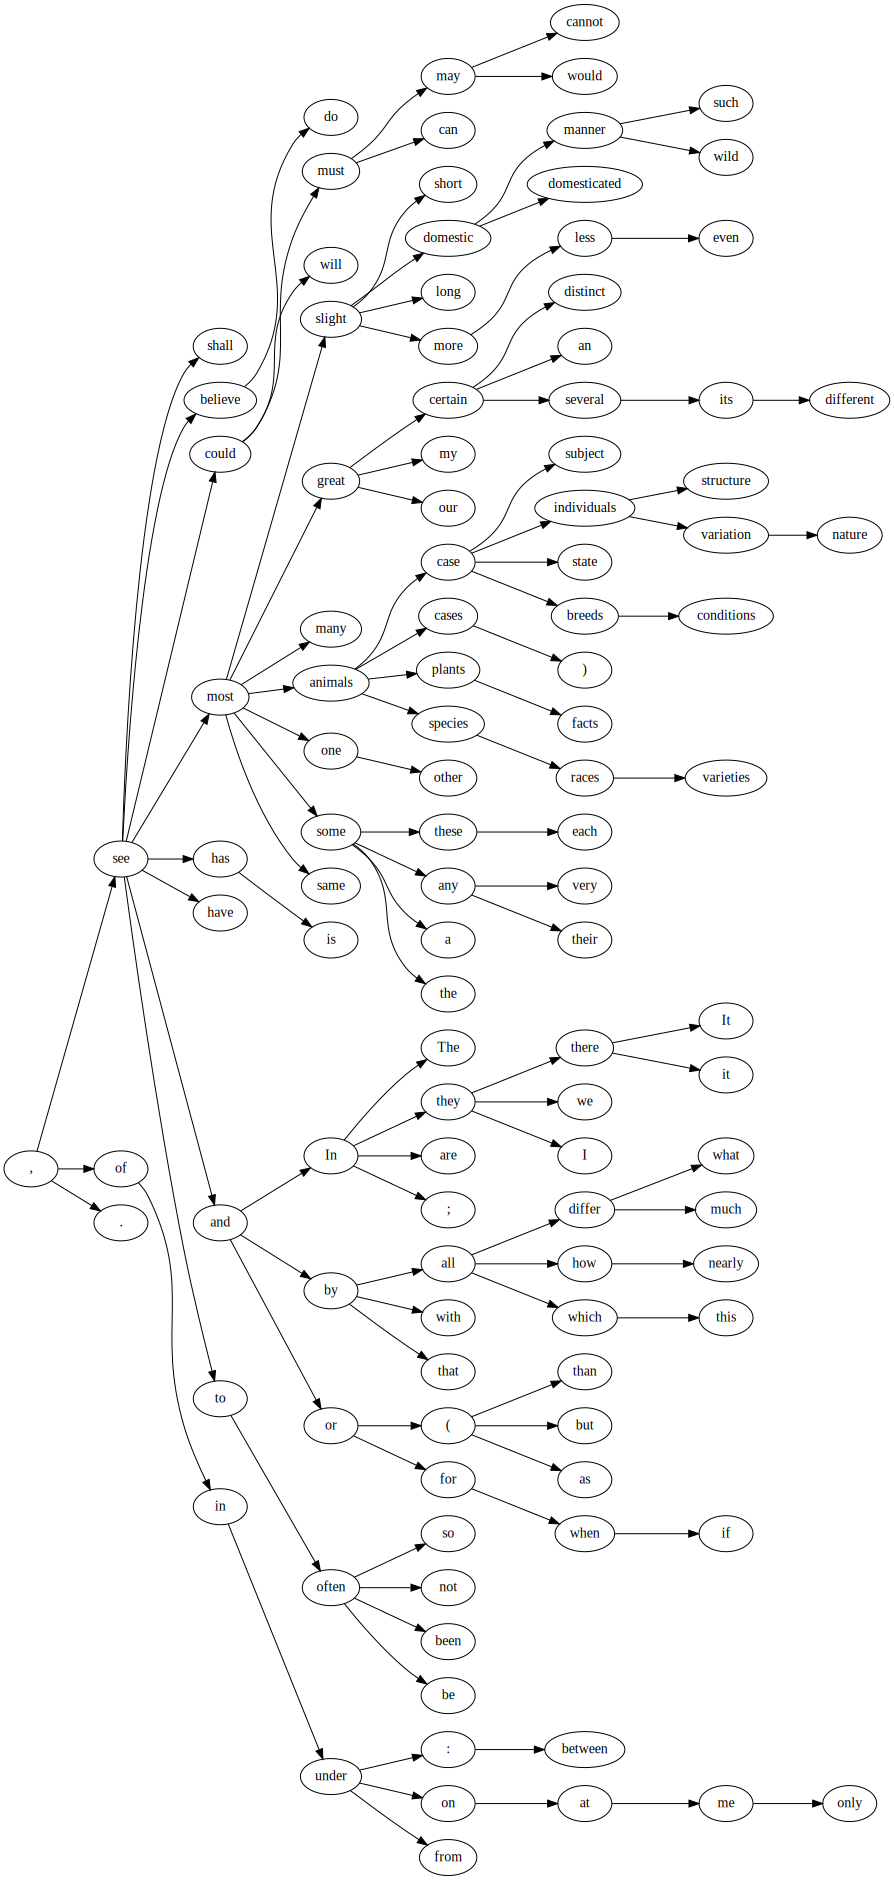

CPU times: user 1min 11s, sys: 24.5 ms, total: 1min 11s
Wall time: 1min 11s


In [6]:
%%time
merge_history, class_members = compute_full_hierarchy("data/TEXTEN1.ptg", 0, occurence_threshold=10, line_limit=8000, save_class_members_at_k=15)
display_experiment("English words", merge_history, class_members)

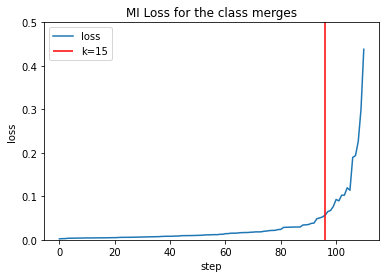

In [20]:
ax = pd.DataFrame(merge_history).reset_index().plot(x='index', y='loss', title="MI Loss for the class merges", xlabel="step", ylabel="loss")
ax.vlines(x=111-15, ymin=-0.1, ymax=0.6, colors='r', label="k=15")
ax.legend()
ax.set_ylim(0, 0.5);

In [16]:
# Compute count of tags for specific word classes - useful for explaining the classes
def tag_probs(words):
    line_list = read_word_list("data/TEXTEN1.ptg")
    word_list = [word.split("/", 1) for word in line_list]
    
    class_counter = Counter()
    for w in words:
        tag_counter = Counter()
        for word, tag in word_list:
            if word == w:
                tag_counter.update([tag])
        class_counter.update([tag_counter.most_common()[0][0]])
    class_counter = class_counter.most_common()
    return {"words":words, "tags":class_counter, "prop. of most common":"{:.2f}%".format(100*class_counter[0][1]/len(words))}
pd.DataFrame(tag_probs(words) for class_name, words in class_members.items())

,words,tags,prop. of most common
0,"[on, in, me, :, from, at, only, under, between]","[(IN, 6), (PRP, 1), (:, 1), (RB, 1)]",66.67%
1,[.],"[(., 1)]",100.00%
2,"[as, and, for, (, but, than, if, or, when]","[(IN, 4), (CC, 3), ((, 1), (WRB, 1)]",44.44%
3,"[,]","[(,, 1)]",100.00%
4,"[I, it, we, It, they, there]","[(PRP, 5), (EX, 1)]",83.33%
5,"[much, with, that, this, by, all, which, nearly, how, what, differ]","[(IN, 3), (DT, 2), (JJ, 1), (WDT, 1), (RB, 1), (WRB, 1), (WP, 1), (VBP, 1)]",27.27%
6,"[certain, one, our, my, short, same, many, more, several, most, other, such, even, its, distinct, domesticated, great, slight, long, manner, less, an, different, domestic, wild]","[(JJ, 14), (PRP$, 3), (JJR, 2), (CD, 1), (RBS, 1), (RB, 1), (VBN, 1), (NN, 1), (DT, 1)]",56.00%
7,"[facts, species, subject, ), cases, varieties, structure, conditions, variation, case, animals, plants, state, nature, individuals, races, breeds]","[(NNS, 9), (NN, 7), (SYM, 1)]",52.94%
8,[the],"[(DT, 1)]",100.00%
9,[of],"[(IN, 1)]",100.00%


## Discussion: English word hierarchy
First we inspect the merge history. We see that the loss for the merge pairs increases almost monotonically. Towards the end of the merging we see that the merges are quickly becoming too agressive and decrease the total mutual information too much. When we look at the classes we merge at that stage they don't make as much sense as the merges in the beginning when it is much easier to find two very similar classes. We also noticed that our implementation runs non-deterministically and towards the end of the computation may output different order of the merges. This further proves the point that the merges at the end are not that useful since they depend on the ordering of the classes in the data structures.

For this reason it makes more sense to look at the word classes before these high-loss merges. We therefore look at the intermediary class hierarchy at number of classes `k=15`. 

There we can see five singleton word classes (the, of, to, "." and ","). These classes were not merged with anything else up until this point and so we can hypothesize that they "behave" very distinctly compared to all other classes. 

Interestingly the capitalized version of the class "the" has been merged together with the words ";", "In", "are", "The". This is contraintuitive because it would seem natural that the determiners function similarly independent on their capitalization. 

One explanation could be that the first merge that occured for this class "The" was with the capitalized preposition "In" because they functioned similarly at the begginings of sentences. From that point the class diverged from containing only one determiner and so was not suited for merging in with the other determiner "the". To analyze this further we ran the algorithm again and compared the loss of merging "The" and "In" and the loss of merging "The" and "the". We hypothesize that the greedy algorithm could have made a suboptimal choice when merging these two classes since it makes intuitively more sense to merge the determiners together. This doesn't seem to be the case though since the loss for merging "The" and "the" is 5-6 times larger than the locally optimal choice of merging "The" and "In" at that step of the algorithm.

Moving on to the larger classes, we observe that there seems to be an overlap between our classes and liguistically defined part of speech classes. More specifically the class "on, in, me, :, from, at, only, under, between" contains 6 prepositions out of 9 words, the class "as, and, for, (, but, than, if, or, when" contains (coordinating and subordinating) conjunctions, the class "I, it, we, It, they, there" contains personal pronouns, the class "certain, one, our, my, short, same, ..." contains a majority of adverbs and possesive pronouns, the class "facts, species, subject, ..." contains nouns, the class "will, has, could, ..." contains modal verbs and some forms of verb be, "some, any, these, ..." contains determiners

Still considering the part of speech classification inside the classes we found, the most varied classes are ";, In, are, The" and "much, with, that, this, by, all, which, nearly, how, what, differ". We cannot say that one or two tags dominate these categories. The first varied class contains two capitalized words - we can hypothesize that this class somehow relates to beginnings of sentences - but the other two words don't seem to fit this pattern. The second varied class also doesn't seem to fit any preexisting linguistic category.

In [63]:
%%time
merge_history, class_members_k15 = compute_full_hierarchy("data/TEXTCZ1.ptg", 0, occurence_threshold=10, line_limit=8000, save_class_members_at_k=15)
display_experiment("Czech words", merge_history, class_members_k15)

,word A,word B,loss,total mi
0,listopadu,OKD,0.00308326967931,7.55796422078146
1,který,které,0.00337385337384,7.55488095110215
2,státu,J,0.00402546955122,7.55150709772831
3,musí,bude,0.00442215293517,7.54748162817709
4,aby,ale,0.00460435822410,7.54305947524192
...,...,...,...,...
55,v,jako,0.14992320881387,6.27583518341020
56,",",na,0.17447070257058,6.12591197459632
57,:,.,0.21505451995886,5.95144127202576
58,v,",",0.29478006339041,5.73638675206705


,class name,members
0,V,"[V, Na, "", listopadu, OKD]"
1,.,[.]
2,:,"[:, -, po, pro]"
3,o,"[(, byl, o, jsou, pouze, si]"
4,",","[,]"
5,ve,"[), ve, J, z, ČSFR, státu, NATO, &slash;]"
6,včera,"[včera, i, by, je, nás, bylo]"
7,ze,"[k, zákona, jeho, ze, to, při]"
8,se,[se]
9,a,[a]


CPU times: user 20.5 s, sys: 16.6 ms, total: 20.5 s
Wall time: 20.9 s


## Discussion: Czech word hierarchy

Generally speaking in the Czech setting we start the clustering with approx. half the classes compared to the English case. This results in smaller classes that are a harder to interpret. We have similar singleton classes ".", ",", "se", "a", "na", "v". Then we have classes that are more easy to interpret: for example the class "do, od, bude, být, mezi, už, za, u, musí, však" contain a lot of prepositions. The class "který, že, aby, ale, které" contain conjunctions and relative pronouns - both of these can connect dependent clause to the main clause.

The rest of the clases seem to be harder to interpret. Including more words into the corpus might help us gather more examples for each class and make the task of interpreting them easier.

# Tag Classes

Use the same original data as above, but this time, you will compute the classes for tags (the strings after slashes). Compute tag classes for all tags appearing 5 times or more in the data. Use as much data as time allows. You will be graded relative to the other student's results. Again, note the full history of merges, and attach it to your homework. Pick three interesting classes as the algorithm goes (English data only; Czech optional), and comment on them (why you think you see those tags there together (or not), etc.).

,word A,word B,loss,total mi
0,WP$,RBR,0.00021893989181,0.88331683271931
1,WP$,JJR,0.00034888337197,0.88309789282750
2,SYM,NNPS,0.00081936225086,0.88274900945553
3,PRP,EX,0.00108471004269,0.88192964720467
4,FW,NNP,0.00121859340867,0.88084493716198
...,...,...,...,...
30,WRB,(,0.08058638916593,0.48184011777709
31,WP$,PRP$,0.07991537216913,0.40125372861115
32,WRB,IN,0.09845339877722,0.32133835644202
33,WP$,WRB,0.19133382618914,0.22288495766481


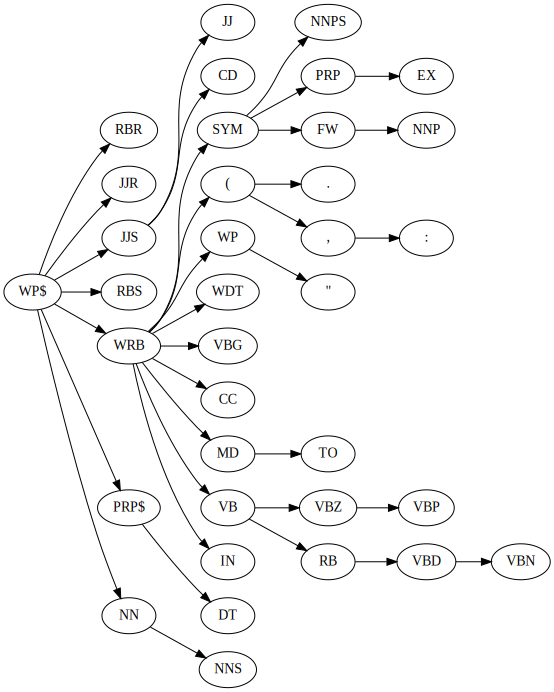

CPU times: user 12.1 s, sys: 3.34 ms, total: 12.1 s
Wall time: 12.4 s


In [101]:
%%time
merge_history, class_members = compute_full_hierarchy("data/TEXTEN1.ptg", 1, occurence_threshold=5, line_limit=999999, save_class_members_at_k=23)
display_experiment("English tags", merge_history, None)

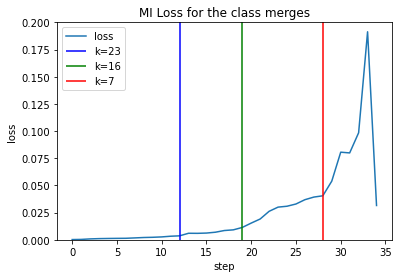

In [106]:
ax = pd.DataFrame(merge_history).reset_index().plot(x='index', y='loss', title="MI Loss for the class merges", xlabel="step", ylabel="loss")
ax.vlines(x=12, ymin=-0.1, ymax=0.3, colors='b', label="k=23")
ax.vlines(x=19, ymin=-0.1, ymax=0.3, colors='g', label="k=16")
ax.vlines(x=28, ymin=-0.1, ymax=0.3, colors='r', label="k=7")
ax.legend()
ax.set_ylim(0, 0.2);

In [103]:
display(HTML(f'<h2>Class members for 23 classes</h2>'))
display(pd.DataFrame({
    "class name": class_members.keys(),
    "members":  class_members.values()
}))

,class name,members
0,WRB,"[WRB, WP, ""]"
1,IN,[IN]
2,NN,[NN]
3,SYM,"[NNP, SYM, NNPS, FW]"
4,(,"[., (]"
5,",","[,]"
6,PRP,"[PRP, EX]"
7,VBD,[VBD]
8,JJS,"[JJ, CD, JJS]"
9,NNS,[NNS]


In [104]:
merge_history, class_members = compute_full_hierarchy("data/TEXTEN1.ptg", 1, occurence_threshold=5, line_limit=999999, save_class_members_at_k=16)
display(HTML(f'<h2>Class members for 16 classes</h2>'))
display(pd.DataFrame({
    "class name": class_members.keys(),
    "members":  class_members.values()
}))

,class name,members
0,WRB,"[WRB, VBG, WDT, WP, ""]"
1,IN,[IN]
2,NN,"[NN, NNS]"
3,SYM,"[NNP, SYM, NNPS, FW]"
4,(,"[., (]"
5,",","[,, :]"
6,PRP,"[PRP, EX]"
7,VBD,"[VBD, VBN]"
8,WP$,"[JJ, CD, JJS, JJR, RBS, RBR, WP$]"
9,PRP$,"[DT, PRP$]"


In [105]:
merge_history, class_members = compute_full_hierarchy("data/TEXTEN1.ptg", 1, occurence_threshold=5, line_limit=999999, save_class_members_at_k=7)
display(HTML(f'<h2>Class members for 7 classes</h2>'))
display(pd.DataFrame({
    "class name": class_members.keys(),
    "members":  class_members.values()
}))

,class name,members
0,WRB,"[WRB, NNP, PRP, VBG, CC, TO, MD, WDT, SYM, WP, EX, "", NNPS, FW]"
1,IN,[IN]
2,NN,"[NN, NNS]"
3,(,"[., ,, :, (]"
4,VB,"[VBD, VB, VBN, VBZ, RB, VBP]"
5,WP$,"[JJ, CD, JJS, JJR, RBS, RBR, WP$]"
6,PRP$,"[DT, PRP$]"


## Discussion: English tag hierarchy

For the tag classes we run the experiment three times to get 23, 16 and 7 classes. We determined these numbers by observing the loss curve and picking numbers before higher loss increases. The clustering therefore becomes more and more aggresive with decreasing number of classes `k`.

The class that can be found across all three `k` settings is the class \[DT, PRP\$\]. The fact that the class was created early and was not merged up until the end of the computation (at 4th last step) indicates that the these two tags are very much related and are also distinct from all other tags. The class contains Determiners and Possessive pronouns. This combination makes a lot of sense because Determiners and Possessive pronouns are used very similarly - compare "**his** car was waiting" and "**the** car was waiting". These parts of speech can be somehow used interchangebly.

In the most conservative setting with `k=23` we can also see classes containing 4 tags already. For example the class
[NNP, SYM, NNPS, FW] contains proper nouns, symbols and foreign words. This class seems to cover proper names as they can also contain symbols and foreign words.
At `k=16` and `k=7` we see the reoccuring class [NN, NNS], singular and plural nouns clustered together. Another reoccuring class at both of these levels is [JJ, CD, JJS, JJR, RBS, RBR, WP\$]. It contains adjectives, cardinal numbers, comparative and superlative adverbs and Possessive wh-pronoun. These tags can occur before nouns very often.

,word A,word B,loss,total mi
0,P4FS1----------,P4YS1----------,0.00052488241818,2.40619692313184
1,P4NS1----------,P4FP1----------,0.00081426585598,2.40567204071366
2,NNFXX-----A---8,Cn-S1----------,0.00083757657880,2.40485777485768
3,PQ--4----------,PQ--1----------,0.00100012501563,2.40402019827887
4,Db------------8,NNMXX-----A---8,0.00116792524132,2.40302007326325
...,...,...,...,...
155,VpTP---XR-AA--1,NNFP4-----A----,0.09720382428554,0.63134023061318
156,VpTP---XR-AA--1,J^-------------,0.11111695590658,0.53413640632764
157,RV--6----------,NNFS6-----A----,0.11359663413584,0.42301945042106
158,RV--6----------,NNNS7-----A----,0.10693886500579,0.30942281628522


,class name,members
0,NNMS1-----A----,"[C}-------------, NNMS1-----A----, NNFXX-----A----, X@-------------, C=-------------, NNFP2-----A----, NNNXX-----A----, Db------------8, NNMP2-----A----, NNMS7-----A----, NNIP2-----A----, NNIXX-----A---8, VsQW---XX-AP---, NNFXX-----A---8, NNMP3-----A----, AAMS1----1A----, AAXXX----1A----, VsNS---XX-AP---, PDZS3----------, XX-------------, Cn-S1----------, NNMXX-----A---8]"
1,J^-------------,"[Z:-------------, J^-------------]"
2,PSXXXXP3-------,"[J,-------------, VB-P---3P-NA---, P4FS1----------, Db-------------, VsYS---XX-AP---, P7-X4----------, Dg-------1A----, AAIP1----1A----, Xx-------------, P4YS1----------, VpYS---XR-AA--1, J,-X---3-------, PSXXXXP3-------, AGFS1-----A----, Dg-------2A----, PDNS1----------, Vc-X---3-------, Db------------1, PDNS4----------, VpNS---XR-NA---, P4FP1----------, TT-------------, NNNP1-----A----, VB-S---1P-AA---, PQ--4----------, PP-P4--1-------, P4NS1----------, NNIS3-----A----, P7-X3----------, AAIS3----1A----, PQ--1----------]"
3,VB-P---3P-AA---,"[VB-S---3P-AA---, VpYS---XR-AA---, VpQW---XR-AA---, VpTP---XR-AA---, VB-P---1P-AA---, VpMP---XR-AA---, VB-S---3P-NA---, VB-S---3F-AA---, VB-P---3P-AA---, VpNS---XR-AA---, VB-P---3F-AA---]"
4,NNNS1-----A----,"[NNNS1-----A----, NNFS1-----A----, NNIS1-----A----, NNMP1-----A----, NNFP1-----A----]"
5,RR--7----------,"[RR--7----------, AANS7----1A----, AAIS7----1A----, RV--7----------, AAFS7----1A----]"
6,NNFP4-----A----,"[NNFS4-----A----, NNIS4-----A----, NNMS2-----A----, NNFP3-----A----, NNNP2-----A----, NNMP4-----A----, NNMS4-----A----, AAFP4----1A----, NNFP4-----A----, NNNS3-----A----, NNFS3-----A----, AANS4----1A----, NNNS4-----A----, NNIP4-----A----, NNIP3-----A----, AAIP4----1A----]"
7,RR--3----------,"[RR--4----------, RR--3----------, Vf--------A----, AAFS4----1A----, RV--3----------, AAIS4----1A----, AANS3----1A----, Cn-S4----------, AANP2----1A----, AAMP4----1A----]"
8,NNIS2-----A----,"[NNNS2-----A----, NNFS2-----A----, NNIS2-----A----, AAFP2----1A----, NNFPX-----A----, ClXP2----------, PDXP2----------, Cn-P2----------, PP-P2--1-------, AAMP2----1A----, AAIP2----1A----, PDZS2----------]"
9,AAIS2----1A----,"[AAFS2----1A----, RR--2----------, AAIS2----1A----, PSXXXZS3-------, AANS2----1A----, RV--2----------]"


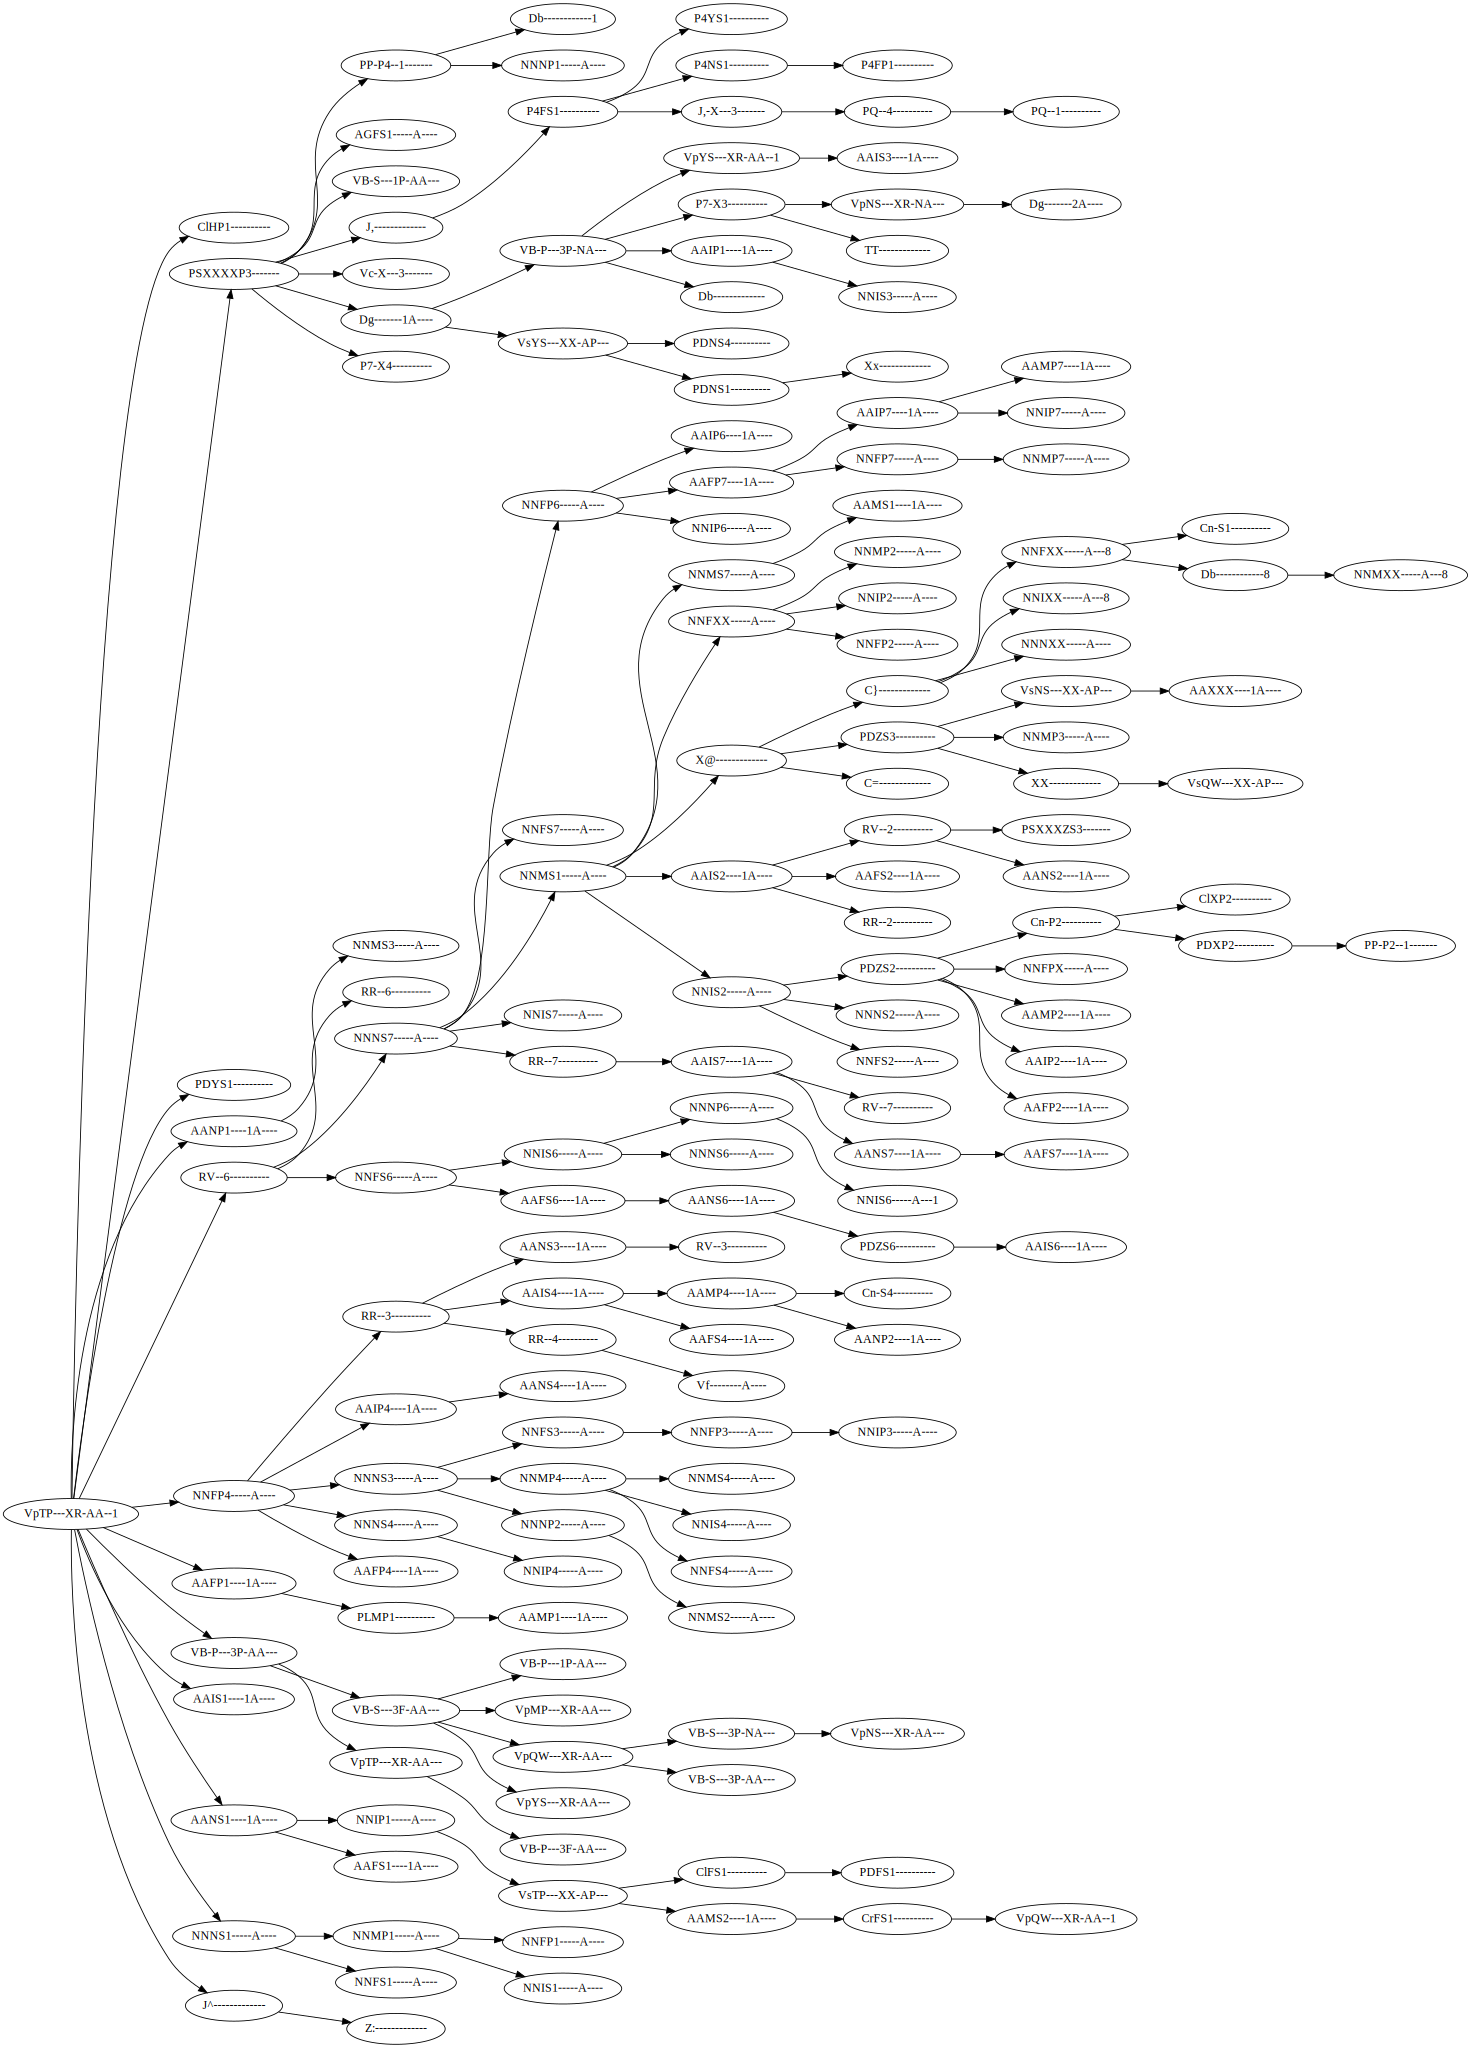

CPU times: user 1min 53s, sys: 56.1 ms, total: 1min 53s
Wall time: 1min 54s


In [10]:
%%time
merge_history, class_members_k15 = compute_full_hierarchy("data/TEXTCZ1.ptg", 1, occurence_threshold=5, line_limit=8000, save_class_members_at_k=15)
display_experiment("Czech tags", merge_history, class_members_k15)